# Time Series Forecasting with LSTM

[Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from scipy.integrate import simps

In [2]:
SEED = 42
np.random.seed(SEED)

## Load Data
[International airline passengers](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv): monthly totals in thousands. Jan 49 – Dec 60 

Source: Time Series Data Library (citing: Box & Jenkins (1976))

In [3]:
filename = 'airline-passengers.csv'
airline_df = pd.read_csv(filename, header=0, parse_dates=['Month'])
airline_df.rename(columns={c: c.lower() for c in  airline_df.columns}, inplace=True)
# airline_df['month'] = pd.to_datetime(airline_df['month'])
airline_df.set_index('month', inplace=True)
airline_df.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Plot

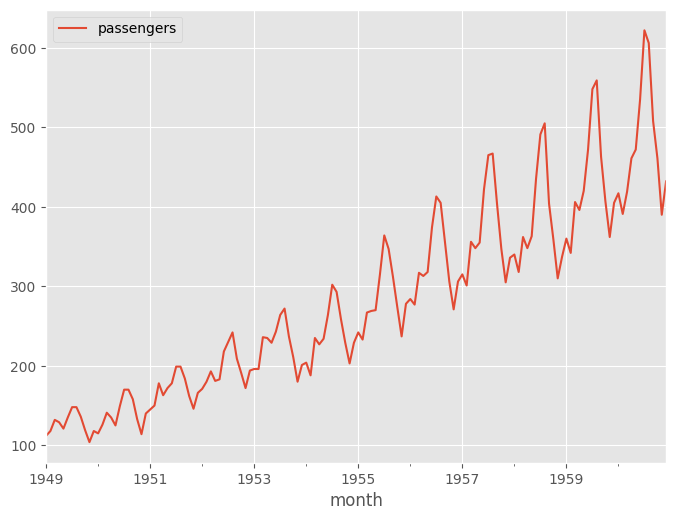

In [4]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

airline_df.plot(ax=ax)

plt.show()

## Transform Data

In [5]:
# split a univariate sequence into samples
def lstm_split_sequence(sequence, n_steps_in, n_steps_out=1):
    X, y = list(), list()
    for i in range(len(sequence) - n_steps_in):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if end_ix > len(sequence)-n_steps_out:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [6]:
train_test_split_ratio = 0.8

def train_test_split(current_df, col, n_steps_in, n_steps_out=1):
    # split into samples
    X, y = lstm_split_sequence(current_df[[col]].values, n_steps_in, n_steps_out)
    print('shapes:', X.shape, y.shape)
    split_index = round(len(X) * train_test_split_ratio)
    
    # split sequences
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test

## Univariate LSTM

In [7]:
n_features = 1

#### Split Data

In [8]:
n_steps_in, n_steps_out = 12, 1
col = 'passengers'

X_train, X_test, y_train, y_test = train_test_split(airline_df, col, n_steps_in)

test_len = y_test.shape[0]

print('Train')
print(X_train.shape, y_train.shape)
# for i in range(2):
#     print(X_train[i], y_train[i])
# print(airline_df.head())
# for i in range(-2,0):
#     print(X_train[i], y_train[i])

print('Test')
print(X_test.shape, y_test.shape)
# for i in range(2):
#     print(X_test[i], y_test[i])
# print(airline_df.tail())
# for i in range(-2,0):
#     print(X_test[i], y_test[i])

shapes: (132, 12, 1) (132, 1, 1)
Train
(106, 12, 1) (106, 1, 1)
Test
(26, 12, 1) (26, 1, 1)


In [9]:
airline_df.tail()

,passengers
month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


### Vanilla

#### Define

In [10]:
vanilla_lstm_model = Sequential()
vanilla_lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
vanilla_lstm_model.add(Dense(1))
vanilla_lstm_model.compile(optimizer='adam', loss='mse')
vanilla_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### Fit

In [11]:
vanilla_lstm_model.fit(X_train, y_train, epochs=200, verbose=0)

#### Predict

In [12]:
vanilla_lstm_y_hat = vanilla_lstm_model.predict(X_test, verbose=0)

#### Plot

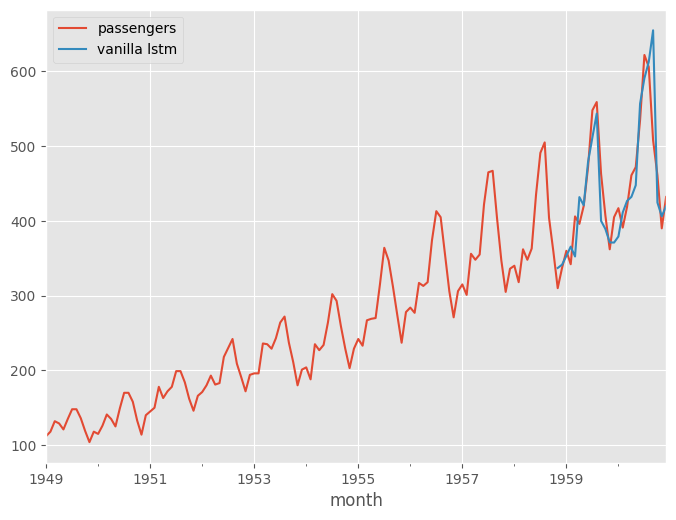

In [13]:
test_idx = airline_df.iloc[-test_len:].index

vanilla_forecast_df = pd.DataFrame({'vanilla lstm': vanilla_lstm_y_hat.flatten(),},
                           index=test_idx)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

airline_df.plot(ax=ax)
vanilla_forecast_df.plot(ax=ax)

plt.show()

### Stacked

[Stacked LSTM](https://machinelearningmastery.com/stacked-long-short-term-memory-networks/)

#### Define

In [14]:
# define model
stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
stacked_lstm_model.add(LSTM(50, activation='relu'))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(optimizer='adam', loss='mse')
stacked_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### Fit

In [15]:
stacked_lstm_model.fit(X_train, y_train, epochs=200, verbose=0)

#### Predict

In [16]:
stacked_lstm_y_hat = stacked_lstm_model.predict(X_test, verbose=0)

#### Plot

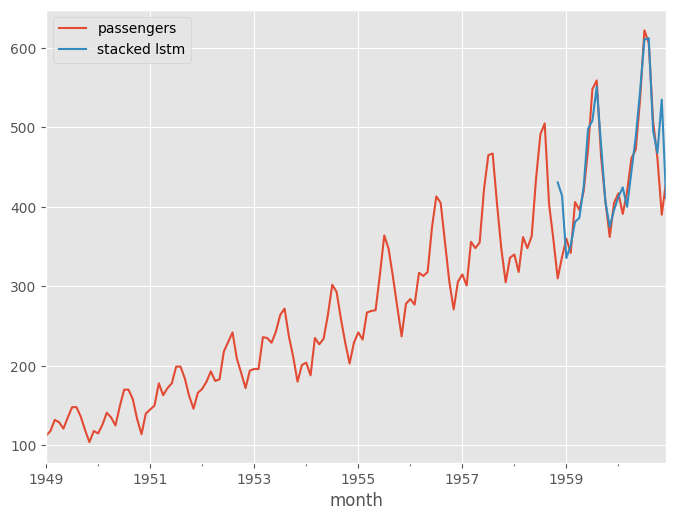

In [17]:
test_idx = airline_df.iloc[-test_len:].index

stacked_forecast_df = pd.DataFrame({'stacked lstm': stacked_lstm_y_hat.flatten(),},
                           index=test_idx)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

airline_df.plot(ax=ax)
stacked_forecast_df.plot(ax=ax)

plt.show()

### Bidirectional

[Bidirectional LSTM](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

#### Define

In [18]:
# define model
bidirectional_lstm_model = Sequential()
bidirectional_lstm_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps_in, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(optimizer='adam', loss='mse')
bidirectional_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


#### Fit

In [19]:
bidirectional_lstm_model.fit(X_train, y_train, epochs=200, verbose=0)

#### Predict

In [20]:
bidirectional_lstm_y_hat = bidirectional_lstm_model.predict(X_test, verbose=0)

#### Plot

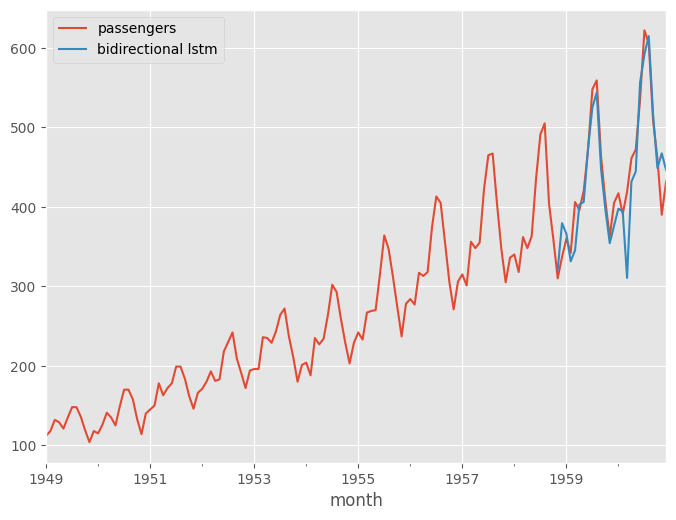

In [21]:
test_idx = airline_df.iloc[-test_len:].index

bidirectional_forecast_df = pd.DataFrame({'bidirectional lstm': bidirectional_lstm_y_hat.flatten(),},
                           index=test_idx)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

airline_df.plot(ax=ax)
bidirectional_forecast_df.plot(ax=ax)

plt.show()

### Compare Models

#### Plot

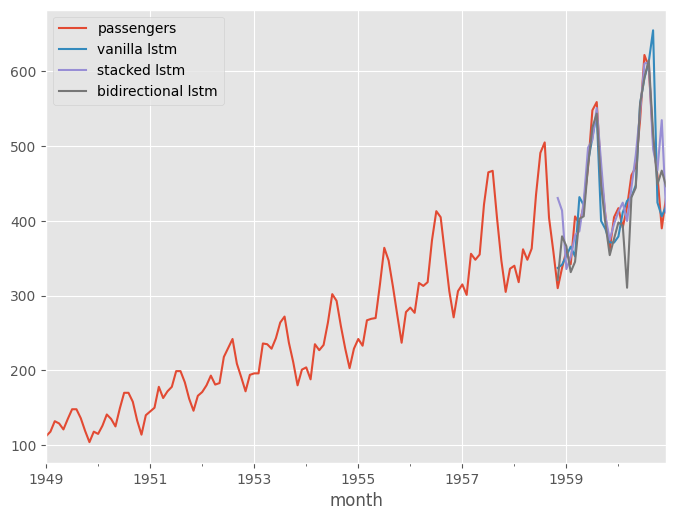

In [22]:
forecast_df = pd.DataFrame({'vanilla lstm': vanilla_lstm_y_hat.flatten(),
                            'stacked lstm': stacked_lstm_y_hat.flatten(),
                            'bidirectional lstm': bidirectional_lstm_y_hat.flatten(),
                           },
                           index=test_idx)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

airline_df.plot(ax=ax)
forecast_df.plot(ax=ax)

plt.show()

#### Zoom Plot

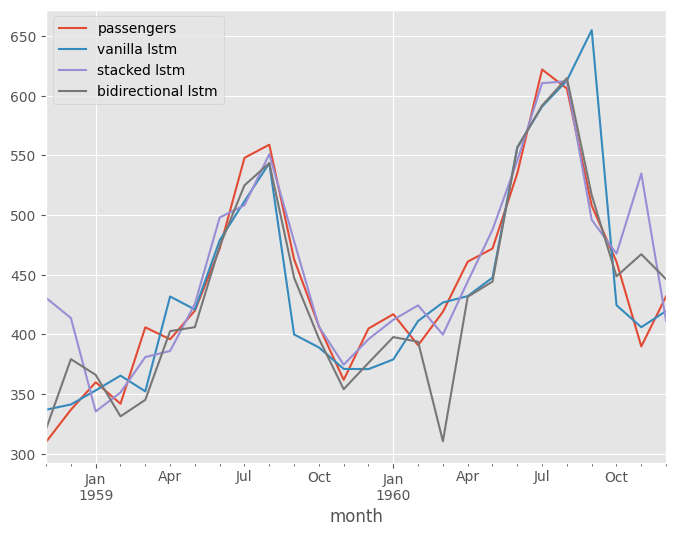

In [23]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

airline_df.loc[test_idx].plot(ax=ax)
forecast_df.plot(ax=ax)

plt.show()

#### Calculate Scores

In [24]:
def rmse(y, y_pred):
    """Root mean squared error. """
    return np.sqrt(np.mean((y - y_pred) ** 2))

def mae(y, y_pred):
    """Mean Absolute Error. """
    return np.mean(np.abs(y - y_pred))

def mape(y, y_pred):
    """Mean Absolute Percentage Error (scale invariant)"""
    return 100.0 * np.mean(np.abs((y - y_pred) / y))

def calc_scores(y, y_pred):
    """Calculates several error metrics for given actuals and predictions."""
    
    return {'RMSE': rmse(y, y_pred),
            'MAE': mae(y, y_pred),
            'MAPE': mape(y, y_pred)}

In [25]:
scores = {}
for c in forecast_df.columns:
    scores[c] = calc_scores(airline_df.loc[test_idx, 'passengers'], forecast_df[c])

scores_df = pd.DataFrame(scores).T
scores_df

,RMSE,MAE,MAPE
vanilla lstm,39.614583,27.899744,6.253066
stacked lstm,43.220771,26.331578,6.778626
bidirectional lstm,33.748209,23.652776,5.565911


#### [Regression Error Characteristic Curves](https://jinbo-bi.uconn.edu/rec/)

Receiver Operating Characteristic (ROC) curves provide a powerful tool for visualizing and comparing classification results. **Regression Error Characteristic** (REC) curves generalize ROC curves to regression.

In [26]:
def rec_curve(y, y_hat):
    """
    
    """
    # as a null model we take y.mean()
    diff = np.abs(y-y.mean()).mean()
    # remove coupled Nulls
    left = ~(np.isnan(y) | np.isnan(y_hat))
    y, y_hat = y[left], y_hat[left]
    # Calculate Loss
    loss = np.abs(y-y_hat)
    # initialize error terms (Epsilon)
    error = np.linspace(0, diff, 101)
    # for each Epsilon calculate accuracy
    accuracy = np.array([float((loss <= e).sum()/len(loss)) for e in error])
    # Calculate Area Under Curve using Simpson's rule
    auc = simps(accuracy , error ) / diff
    aoc = 1 - auc
    
    return error, accuracy, aoc, r2_score(y , y_hat)

def plot_rec_curve(y, y_hat, forecast_name = ''):
    Deviation, Accuracy, AOC, RR = rec_curve(y, y_hat)
    # Plotting
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title(forecast_name)
    plt.scatter(y, y_hat, color = "darkorange")
    plt.xlabel("Measured")
    plt.ylabel("Predicted")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.text(np.quantile(y, .50),
             np.quantile(y, .1),
             r"$R^2 = %0.4f$" % RR,
             fontsize=15)

    plt.subplot(1, 2, 2)
    plt.title("Regression Error Characteristic (REC)")
    plt.plot(Deviation, Accuracy, "--b",lw =3)
    plt.xlabel("Deviation")
    plt.ylabel("Accuracy")
    plt.plot([Deviation.min(), Deviation.max()], [Accuracy.min(), Accuracy.max()], 'k--', lw=2)
    plt.text(np.average([np.min(Deviation), np.max(Deviation)]),
             np.average([np.min(Accuracy), np.max(Accuracy)], weights=[0.9, 0.10]),
             "AOC = %0.4f" % AOC,
             fontsize=15)

    plt.show()

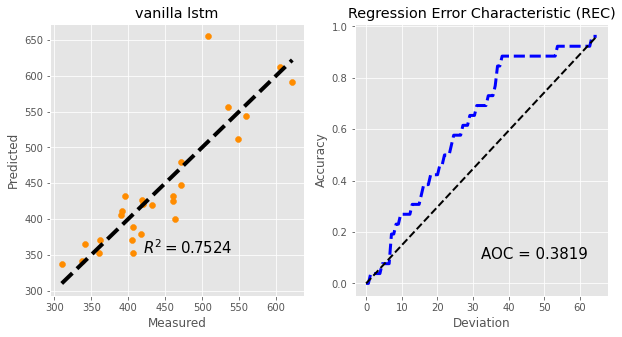

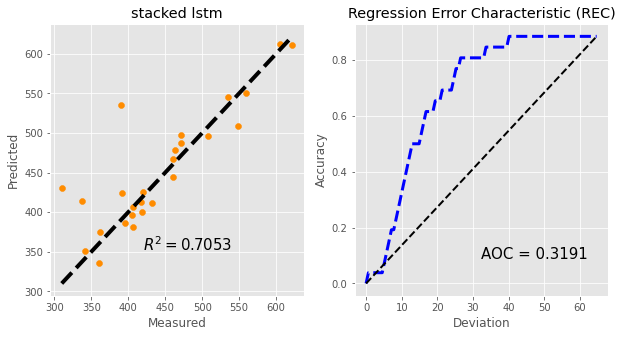

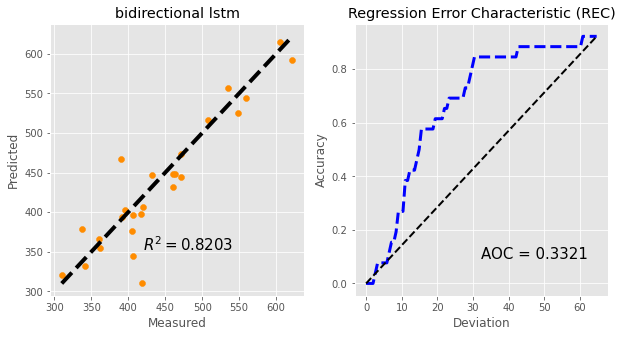

In [27]:
for c in forecast_df.columns:
    plot_rec_curve(airline_df.loc[test_idx, 'passengers'], forecast_df[c], c)
